In [56]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [68]:
import pandas as pd
# from library.lib_aws import AddData
from library.lib_dyna import CardFunctions
from config import username, password, endpoint, data_path
import boto3

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Options
mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
pd.set_option('display.max_rows', 1000)

In [3]:
import sqlalchemy
from sqlalchemy.orm import Session
# from config import username, password, endpoint
from io import StringIO
import csv
import time
from geoalchemy2 import Geometry
import sys
import os

# Helps with relative imports from outside
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# DataBase Classes
class PostgresRDS(object):
    """
    Class Connects to a PostgreSQL DB with password access
    Need to input the database that needs to be connected to
    Note Set the username, password and endpoint in the config file via env variables
    """

    def __init__(self, db, verbose=0):
        self.engine = None
        self.Session = None
        self.db = db
        self.vprint = print if verbose != 0 else lambda *a, **k: None

    def connect(self):
        """
        Connects to the db and gives us the engine
        :return: engine
        """
        engine_config = {
            'sqlalchemy.url': 'postgresql+psycopg2://{user}:{pw}@{host}/{db}'.format(
                user=username,
                pw=password,
                host=endpoint,
                db=self.db
            ),
            'sqlalchemy.pool_pre_ping': True,
            'sqlalchemy.pool_recycle': 3600
        }

        engine = sqlalchemy.engine_from_config(engine_config, prefix='sqlalchemy.')
        self.Session = Session(engine)

        return engine

    def __enter__(self):
        self.engine = self.connect()
        self.vprint("Connected to {} DataBase".format(self.db))
        return self.engine

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.Session.close()
        self.engine.dispose()
        self.vprint("Connection Closed")


class AddData:
    """
    Class which has methods to add data into a postgres db
    """

    @staticmethod
    def psql_insert_copy(table, conn, keys, data_iter):
        """
        Execute SQL statement inserting data

        Parameters
        ----------
        table : pandas.io.sql.SQLTable
        conn : sqlalchemy.engine.Engine or sqlalchemy.engine.Connection
        keys : list of str
            Column names
        data_iter : Iterable that iterates the values to be inserted
        """
        # gets a DBAPI connection that can provide a cursor
        dbapi_conn = conn.connection
        with dbapi_conn.cursor() as cur:
            s_buf = StringIO()
            writer = csv.writer(s_buf)
            writer.writerows(data_iter)
            s_buf.seek(0)

            columns = ', '.join('"{}"'.format(k) for k in keys)
            if table.schema:
                table_name = '{}.{}'.format(table.schema, table.name)
            else:
                table_name = table.name

            sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
                table_name, columns)
            cur.copy_expert(sql=sql, file=s_buf)

    @staticmethod
    def add_data(df, db, table, schema=None, merge_type='append', card_col=None, index_col=None):
        """
        Method to add data to a postgres db
        :param df: Data in the form of a pandas DataFrame
        :param db: Database Name (str)
        :param table: Table Name (str)
        :param schema: Schema Name (Default is None, in this case will add to the public schema)
        :param merge_type: How to add data. Either 'append' or 'replace'. Default: 'append'
        :param card_col: If Card Columns are present. Default('None')
        :param index_col: If an index column is needed. Default('None')
        :return:
        """
        t0 = time.time()
        if card_col is not None:
            dtype_dict = {i: Geometry("POLYGON") for i in card_col}
        else:
            dtype_dict = None

        if index_col is not None:
            try:
                df.set_index(index_col, inplace=True)
            except KeyError:  # Index Column is already set
                pass

        with PostgresRDS(db=db) as engine:
            try:
                df.to_sql(table, con=engine, schema=schema, if_exists=merge_type, method=AddData.psql_insert_copy,
                          dtype=dtype_dict)
            except Exception as e:
                print(e)
                print("Data Not Added")
                return False

        t1 = time.time()
        print("Data {}ed on Table {} in time {:.2f}s".format(merge_type, table, t1 - t0))
        return True


In [50]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s')

In [55]:
logging.error("Error Bruh")

ERROR:root:Error Bruh


In [45]:
db = 'oasis-dev'
schema = 'stream'

class OasisStream:

    def __init__(self, str_match, table_name, file_path=data_path,
                 date_col='Date', well_col='NodeID', drop_cols=None):
        self.str_match = str_match
        self.table_name = table_name

        self.file_path = file_path
        self.date_col = date_col
        self.well_col = well_col

        self.drop_cols = drop_cols

        self.files = []
        self.add_success = False
        self.transfer_success = False
        self.del_success = False

    def add_to_db(self):
        """
        Imports data from the files and adds it to the database
        """
        frames = []
        for filename in os.listdir(self.file_path):
            if self.str_match in filename:
                self.files.append(filename)
                path = os.path.join(self.file_path, filename)
                temp_df = pd.read_csv(path, error_bad_lines=False)

                frames.append(temp_df)
        
        try:
            data = pd.concat(frames)
        except ValueError:
            return print("Files were not there")
        
        if self.drop_cols is not None:
            data.drop(columns=self.drop_cols)
        
        data.loc[:, self.date_col] = pd.to_datetime(data.loc[:, self.date_col])
        data.drop_duplicates(subset=[self.well_col, self.date_col], inplace=True)
        data.sort_values(by=[self.well_col, self.date_col], inplace=True)
        data.reset_index(inplace=True, drop=True)

        self.add_success = AddData.add_data(df=data, db=db, schema=schema,
                                            table=self.table_name, merge_type='replace',
                                            index_col=self.date_col)

    def transfer_s3(self, location):
        s3 = boto3.resource('s3')

        if self.add_success is False:
            return print("Data hasn't been added to RDS DB")

        for filename in self.files:
            s3.meta.client.upload_file(os.path.join(self.file_path, filename),
                                       "et-oasis", location + filename)
        self.transfer_success = True

    def del_files(self):

        if self.transfer_success is False:
            return print("First Transfer the files")
        if self.add_success is False:
            return print("Add Data to db first")

        for filename in self.files:
            os.remove(os.path.join(self.file_path, filename))
            
        self.del_success = True
        
        return None
            
    def result(self):
        print('Files Worked on:',*self.files, sep='\n')
        print(f'Data added to DB                    : {self.add_success}')
        print(f'Files Transfered to S3              : {self.transfer_success}')
        print(f'Files deleted from {self.file_path} : {self.del_success}')

In [33]:
xdiagrod = OasisStream(str_match='XDiagRod', table_name='xdiagrod')
xdiagrod.add_to_db()
xdiagrod.transfer_s3(location="backup/xdiagRodResults/")
xdiagrod.result()

          NodeID                Date  RodNum       Grade  Length  Diameter  \
0  ACADIA 31-25H 2020-05-25 07:52:18       1  Norris D90    2643       1.0   
1  ACADIA 31-25H 2020-05-25 10:52:17       1  Norris D90    2643       1.0   
2  ACADIA 31-25H 2020-05-25 13:52:19       1  Norris D90    2643       1.0   
3  ACADIA 31-25H 2020-05-25 16:52:20       1  Norris D90    2643       1.0   
4  ACADIA 31-25H 2020-05-25 19:52:19       1  Norris D90    2643       1.0   

     Loading  BottomMinStress  TopMinStress  TopMaxStress  RodGuideID  \
0  74.303031     14289.701172  22047.416016  35595.957031           0   
1  79.048640     14596.981445  21496.103516  36112.890625           0   
2  80.732685     14224.687500  21064.474609  36154.910156           0   
3  75.088239     14128.917969  21874.253906  35626.515625           0   
4  78.667986     14383.172852  21665.443359  36149.816406           0   

   DragFrictionCoefficient  GuideCountPerRod  
0                      0.0                 0 

In [35]:
xdiagres = OasisStream(str_match='XDiagResults', table_name='xdiagresults')
xdiagres.add_to_db()
xdiagres.transfer_s3(location="backup/xdiagresults/")
xdiagres.result()

b'Skipping line 1086: expected 99 fields, saw 100\nSkipping line 3870: expected 99 fields, saw 100\nSkipping line 4729: expected 99 fields, saw 100\n'
b'Skipping line 19576: expected 99 fields, saw 100\n'
b'Skipping line 51928: expected 99 fields, saw 100\nSkipping line 55578: expected 99 fields, saw 100\nSkipping line 56160: expected 99 fields, saw 100\nSkipping line 56505: expected 99 fields, saw 100\nSkipping line 56810: expected 99 fields, saw 100\n'
b'Skipping line 57522: expected 99 fields, saw 100\nSkipping line 57836: expected 99 fields, saw 100\nSkipping line 59353: expected 99 fields, saw 100\nSkipping line 59401: expected 99 fields, saw 100\nSkipping line 61163: expected 99 fields, saw 100\n'
b'Skipping line 71581: expected 99 fields, saw 100\n'
b'Skipping line 83633: expected 99 fields, saw 100\n'
b'Skipping line 204948: expected 99 fields, saw 100\nSkipping line 206571: expected 99 fields, saw 100\n'
b'Skipping line 213430: expected 99 fields, saw 100\nSkipping line 216016

Data replaceed on Table xdiagresults in time 414.55s
Files Worked on:
XDiagResults.E2E.20200728.1116.csv
XDiagResults.E2E.20200728.1200.csv
XDiagResults.E2E.20200728.1300.csv
Data added to DB                    : True
Files Transfered to S3              : True
Files deleted from C:\Users\rai_v\OneDrive\Python Coursera\oasis\data : False


In [47]:
welltest = OasisStream(str_match='WellTests', table_name='welltest', date_col='TestDate')
welltest.add_to_db()
welltest.transfer_s3(location="backup/wellTests/")
welltest.del_files()
welltest.result()

Files were not there
Data hasn't been added to RDS DB
First Transfer the files
Files Worked on:
Data added to DB                    : False
Files Transfered to S3              : False
Files deleted from C:\Users\rai_v\OneDrive\Python Coursera\oasis\data : False


## Card Data

In [36]:
frames = []
files = []
for filename in os.listdir(data_path):
    if 'WellTests' in filename:
        files.append(filename)
        path = os.path.join(data_path, filename)
        print(path)
        temp_df = pd.read_csv(path, error_bad_lines=False)
        frames.append(temp_df)

try:
    df = pd.concat(frames)
except ValueError:
    print("Files were not Present")
    


C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\WellTests.E2E.20200728.1116.csv


In [37]:
df

,NodeID,TestDate,OilRate,WaterRate,GasRate
0,Harrier 44-23 4T,2020-06-02 00:00:00,0.000000,0.000000,0.0000
1,Harrier 44-23 3B,2020-06-02 00:00:00,0.000000,0.000000,0.0000
2,Owan 23-26H,2020-06-02 00:00:00,35.963200,53.343899,25.0000
3,Fred 1-33H,2020-06-02 00:00:00,0.000000,0.000000,0.0000
4,Kelter 7-12H3,2020-06-02 00:00:00,28.365101,31.155899,3.8824
...,...,...,...,...,...
59516,Hagen 31-30H,2020-06-02 00:00:00,0.000000,0.000000,0.0000
59517,Rolfson 20-17H,2020-06-02 00:00:00,21.675100,43.341999,157.0000
59518,Rolfson 29-32H,2020-06-02 00:00:00,0.000000,0.000000,0.0000
59519,Lawlar 23-14H,2020-06-02 00:00:00,0.000000,0.000000,0.0000


In [26]:
print('Files updated',*files, sep='\n')

Print Files updated
XDiagRodResults.E2E.20200716.1724.csv
XDiagRodResults.E2E.20200728.1123.csv


In [31]:
s3 = boto3.resource('s3')

for filename in files:
    s3.meta.client.upload_file(os.path.join(data_path, filename), "et-oasis", "backup/xdiagRodResults/" + filename)

In [20]:
df.drop_duplicates(subset=['NodeID', 'Date'], inplace=True)
df.shapex

(403942, 13)

In [34]:
df.isnull().sum(axis=0)/len(df) * 100

NodeID                    0.000000
Date                      0.000000
CardType                  0.000000
SurfaceCard             100.000000
SPM                       0.000000
StrokeLength              0.000000
Runtime                   0.000000
LoadLimit                 0.000000
PositionLimit             0.000000
DownholeCard            100.000000
Saved                     0.000000
MalLoadLimit              0.649888
MalPositionLimit          0.649888
PredictedCard           100.000000
Area                      0.000000
AreaLimit                 0.000000
PocDHCard               100.000000
CorrectedCard           100.000000
LoadLimit2                0.000000
PositionLimit2            0.000000
LoadSpanLimit             0.000000
HiLoadLimit               0.000000
LoLoadLimit               0.000000
CardArea                  0.000000
ProcessCard               0.000000
FillBasePct               0.000000
TorquePlotMinEnergy     100.000000
TorquePlotMinTorque     100.000000
TorquePlotCurrent   

## Backed Up Large Files
From May 25th to July 28th

### XDiagRod

In [106]:
# Xdiag Results
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\back\XDiagRodResults.E2E.20200728.1123.csv"
xdiag = pd.read_csv(file_path, error_bad_lines=False, parse_dates=['Date'])
display(xdiag.isnull().sum(axis=0)/xdiag.shape[0] * 100)
xdiag.head()

NodeID                     0.0
Date                       0.0
RodNum                     0.0
Grade                      0.0
Length                     0.0
Diameter                   0.0
Loading                    0.0
BottomMinStress            0.0
TopMinStress               0.0
TopMaxStress               0.0
RodGuideID                 0.0
DragFrictionCoefficient    0.0
GuideCountPerRod           0.0
dtype: float64

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
0,Remington 5992 12-26H,2020-06-17 17:26:49,2,D (API),3025,0.875,47.897145,6500.684082,14548.146484,24385.509766,0,0.0,0
1,Remington 5992 12-26H,2020-06-17 17:26:49,3,D (API),1834,0.750,56.273031,1814.843872,5275.181641,19262.542969,0,0.0,0
2,Shaw 24-22H,2020-06-30 23:29:17,3,Weatherford HD,1875,0.750,46.359080,701.121155,2803.714844,23987.546875,0,0.0,0
3,Shaw 24-22H,2020-06-30 23:29:17,4,Weatherford HD,550,1.000,21.284787,-282.689026,-1472.833130,8839.249023,0,0.0,0
4,Norris 5892 21-30B,2020-06-30 23:54:59,1,D (API),2875,1.000,83.160406,10895.191406,19610.435547,34730.152344,0,0.0,0


In [107]:
xdiag.sort_values(by=['NodeID', 'Date'], inplace=True)
xdiag.tail()

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
464995,Zutz 44-12T,2020-07-27 17:52:52,2,D (API),2525,0.875,77.710265,10976.406250,17076.341797,33612.386719,0,0.0,0
474482,Zutz 44-12T,2020-07-27 18:53:39,1,D (API),2375,1.000,67.511195,14726.011719,21119.224609,34290.886719,0,0.0,0
474483,Zutz 44-12T,2020-07-27 18:53:39,2,D (API),2525,0.875,72.784269,11502.493164,17837.169922,33082.734375,0,0.0,0
474484,Zutz 44-12T,2020-07-27 18:53:39,3,D (API),3900,0.750,85.070413,1767.281860,12653.011719,32401.519531,0,0.0,0
474485,Zutz 44-12T,2020-07-27 18:53:39,4,"K (API, Sinker Bar)",410,1.500,49.514970,-519.789673,-1234.821167,10173.543945,0,0.0,0


In [108]:
"""
Test out data
"""
well_name = 'Mawson 43-23T'
test_df = xdiag[xdiag.NodeID == well_name].copy()
test_df.sort_values(by=['Date'], inplace=True)
test_df.reset_index(inplace=True, drop=True)
print('Unique rods:',*test_df.RodNum.unique(), sep='\n')

Unique rods:
1
2
3
4


In [155]:
xdiag.shape[0]

1578746

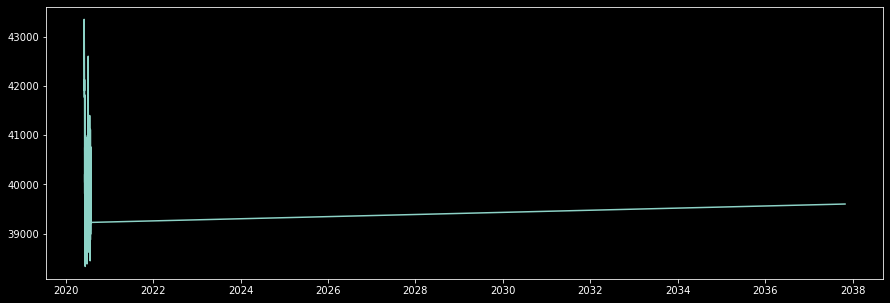

In [109]:
"""
Plot Random KPI
"""
plt.plot(test_df[test_df.RodNum == 1].Date, test_df[test_df.RodNum == 1].TopMaxStress)
plt.show()

In [143]:
"""
Check Error Data Points
"""

current_time = pd.Timestamp.now() - pd.Timedelta('3 days')
test_time = pd.Timestamp('2020-07-29')
uw = xdiag[xdiag.Date > test_time].NodeID.unique()

xdiag[xdiag.Date > test_time].shape[0]

# print(*uw, sep='\n')

288

## XDiagResults

In [88]:
# Xdiag Rod Results
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\back\XDiagResults.E2E.20200728.1116.csv"
xr = pd.read_csv(file_path, parse_dates=['Date'], error_bad_lines=False)
display(xr.isnull().sum(axis=0)/xr.shape[0] * 100)
xr.head()

b'Skipping line 1086: expected 99 fields, saw 100\nSkipping line 3870: expected 99 fields, saw 100\nSkipping line 4729: expected 99 fields, saw 100\n'
b'Skipping line 19576: expected 99 fields, saw 100\n'
b'Skipping line 51928: expected 99 fields, saw 100\nSkipping line 55578: expected 99 fields, saw 100\nSkipping line 56160: expected 99 fields, saw 100\nSkipping line 56505: expected 99 fields, saw 100\nSkipping line 56810: expected 99 fields, saw 100\n'
b'Skipping line 57522: expected 99 fields, saw 100\nSkipping line 57836: expected 99 fields, saw 100\nSkipping line 59353: expected 99 fields, saw 100\nSkipping line 59401: expected 99 fields, saw 100\nSkipping line 61163: expected 99 fields, saw 100\n'
b'Skipping line 71581: expected 99 fields, saw 100\n'
b'Skipping line 83633: expected 99 fields, saw 100\n'
b'Skipping line 204948: expected 99 fields, saw 100\nSkipping line 206571: expected 99 fields, saw 100\n'
b'Skipping line 213430: expected 99 fields, saw 100\nSkipping line 216016

NodeID                                    0.000000
Date                                      0.000000
PumpCond1                               100.000000
PumpCond2                               100.000000
FillagePct                                0.000000
NetProd                                   7.606365
FluidLevelXDiag                           7.606365
ElecCostPerBO                             0.000000
ElecCostMinTorquePerBO                    0.000000
ElectCostMinEnergyPerBO                   0.000000
PumpEffPct                                0.000000
SystemEffPct                              8.030545
PumpStroke                                0.000000
GearBoxLoadPct                            0.000000
MinTorqueGBLoadPct                        0.000000
MinEnergyGBLoadPct                        6.550727
BalanceUnit                               0.000000
TubingPressure                            0.000000
CasingPressure                            0.000000
GrossProd                      

,NodeID,Date,PumpCond1,PumpCond2,FillagePct,NetProd,FluidLevelXDiag,ElecCostPerBO,ElecCostMinTorquePerBO,ElectCostMinEnergyPerBO,...,ElecCostMonthly,GearboxTorqueRating,Friction,MotorLoad,DownholeCapacity24,DownholeCapacityRuntime,DownholeCapacityRuntimeFillage,AdditionalUplift,UpliftCalculationMissingRequirements,AdditionalUpliftGross
0,Helling Trust 42-22 3B,2020-05-25 23:58:00,NaN,NaN,81,68.0,1420.0,0.0,2.16,1.28,...,0.0,0,15.5,12.0,84.4767,84.4767,68.4261,NaN,Unable to determine uplift opportunity. Missi...,NaN
1,NELSON 4-29H,2020-05-26 00:57:00,NaN,NaN,100,56.0,0.0,0.0,0.43,0.42,...,0.0,0,0.5,67.0,131.1750,57.7170,57.7170,NaN,An error occurred trying to determine uplift o...,NaN
2,Chalmers 21-19 6B,2020-05-26 01:55:00,NaN,NaN,100,174.0,3862.0,0.0,2.77,1.56,...,0.0,0,5.0,16.0,179.1150,179.1150,179.1150,NaN,Unable to determine uplift opportunity. Missi...,NaN
3,HAGEN BANKS 5298 42-31 6T,2020-05-26 00:32:00,NaN,NaN,71,202.0,6608.0,0.0,0.79,0.79,...,0.0,0,0.5,53.0,285.3840,285.3840,202.6230,NaN,Unable to determine uplift opportunity. Missi...,NaN
4,Helling Trust 44-22 6B,2020-05-25 23:41:00,NaN,NaN,100,281.0,2260.0,0.0,0.84,0.50,...,0.0,0,0.5,32.0,300.8100,300.8100,300.8100,NaN,Unable to determine uplift opportunity. Missi...,NaN


In [94]:
xr.sort_values(by=['NodeID', 'Date'], inplace=True)
xr.reset_index(inplace=True, drop=True)
xr.tail()

,NodeID,Date,PumpCond1,PumpCond2,FillagePct,NetProd,FluidLevelXDiag,ElecCostPerBO,ElecCostMinTorquePerBO,ElectCostMinEnergyPerBO,...,ElecCostMonthly,GearboxTorqueRating,Friction,MotorLoad,DownholeCapacity24,DownholeCapacityRuntime,DownholeCapacityRuntimeFillage,AdditionalUplift,UpliftCalculationMissingRequirements,AdditionalUpliftGross
436603,Zutz 44-12T,2020-07-27 14:51:00,NaN,NaN,100,NaN,NaN,0.0,0.56,0.51,...,0.0,0,3.5,7.0,131.123,131.123,131.123,NaN,NaN,NaN
436604,Zutz 44-12T,2020-07-27 15:52:00,NaN,NaN,83,NaN,NaN,0.0,0.55,0.51,...,0.0,0,2.0,10.0,135.373,135.373,112.359,NaN,NaN,NaN
436605,Zutz 44-12T,2020-07-27 16:52:00,NaN,NaN,80,108.0,0.0,0.0,0.54,0.50,...,0.0,0,1.5,10.0,135.373,135.373,108.298,NaN,Unable to determine uplift opportunity. Missi...,NaN
436606,Zutz 44-12T,2020-07-27 17:52:00,NaN,NaN,100,117.0,90.0,0.0,0.56,0.51,...,0.0,0,0.5,10.0,135.373,135.373,135.373,NaN,NaN,NaN
436607,Zutz 44-12T,2020-07-27 18:53:00,NaN,NaN,75,103.0,0.0,0.0,0.54,0.50,...,0.0,0,1.0,13.0,137.629,137.629,103.222,NaN,NaN,NaN


In [102]:
well = xr.loc[299999, "NodeID"]
test_df = xr[xr.NodeID == well].copy()
test_df.reset_index(inplace=True, drop=True)
test_df.tail()

,NodeID,Date,PumpCond1,PumpCond2,FillagePct,NetProd,FluidLevelXDiag,ElecCostPerBO,ElecCostMinTorquePerBO,ElectCostMinEnergyPerBO,...,ElecCostMonthly,GearboxTorqueRating,Friction,MotorLoad,DownholeCapacity24,DownholeCapacityRuntime,DownholeCapacityRuntimeFillage,AdditionalUplift,UpliftCalculationMissingRequirements,AdditionalUpliftGross
747,Mawson 43-23T,2020-07-28 00:48:00,NaN,NaN,60,38.0,1224.0,0.23,0.22,0.22,...,314.22,0,1.0,42.0,90.6682,63.4677,38.0806,NaN,NaN,NaN
748,Mawson 43-23T,2020-07-28 01:21:00,NaN,NaN,100,60.0,986.0,0.23,0.21,0.19,...,355.30,0,1.5,25.0,88.6743,62.0720,62.0720,NaN,NaN,NaN
749,Mawson 43-23T,2020-07-28 02:40:00,NaN,NaN,38,39.0,3438.0,0.23,0.25,0.23,...,358.28,0,2.0,50.0,144.3970,101.0780,38.4097,NaN,NaN,NaN
750,Mawson 43-23T,2020-07-28 03:16:00,NaN,NaN,55,35.0,1238.0,0.19,0.20,0.17,...,292.20,0,1.0,42.0,91.3765,63.9636,35.1800,NaN,NaN,NaN
751,Mawson 43-23T,2037-10-28 22:07:00,NaN,NaN,100,NaN,NaN,0.00,0.00,0.00,...,0.22,0,0.5,25.0,94.8133,0.0000,0.0000,NaN,NaN,NaN


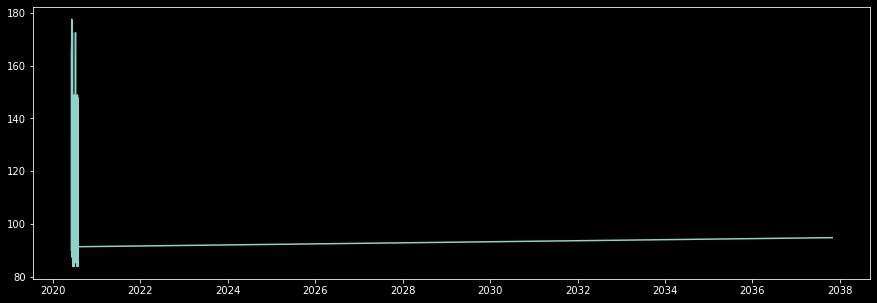

In [103]:
"""
Plot Random KPI
"""
plt.plot(test_df.Date, test_df.DownholeCapacity24)
plt.show()

In [156]:
xr.shape

(436608, 99)

In [144]:
ep = xr[xr.Date > test_time].shape[0]
print(f"Total Error Points: {ep}")
xr[xr.Date > current_time].head()

Total Error Points: 221


,NodeID,Date,PumpCond1,PumpCond2,FillagePct,NetProd,FluidLevelXDiag,ElecCostPerBO,ElecCostMinTorquePerBO,ElectCostMinEnergyPerBO,...,ElecCostMonthly,GearboxTorqueRating,Friction,MotorLoad,DownholeCapacity24,DownholeCapacityRuntime,DownholeCapacityRuntimeFillage,AdditionalUplift,UpliftCalculationMissingRequirements,AdditionalUpliftGross
4569,ARNSTAD 3-10H,2024-05-13 15:39:00,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4570,ARNSTAD 3-10H,2028-12-08 03:30:00,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Unable to determine uplift opportunity. Missi...,NaN
4571,ARNSTAD 3-10H,2029-03-19 18:54:00,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Unable to determine uplift opportunity. Missi...,NaN
4572,ARNSTAD 3-10H,2030-08-03 04:03:00,NaN,NaN,26,NaN,NaN,0.0,0.02,0.0,...,0.0,0,0.5,5.0,106.147,95.5321,24.8384,NaN,Unable to determine uplift opportunity. Missi...,NaN
14935,Angell 31-28H,2028-08-11 19:38:00,NaN,NaN,0,0.0,0.0,0.0,0.00,0.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Card Data

In [157]:
card.shape

(439768, 44)

In [145]:
# Card Data
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\back\CardData.E2E.20200728.1100.csv"
card = pd.read_csv(file_path, parse_dates=['Date'])
display(card.isnull().sum(axis=0)/card.shape[0] * 100)
display(card.head())

NodeID                    0.000000
Date                      0.000000
CardType                  0.000000
SurfaceCard             100.000000
SPM                       0.000000
StrokeLength              0.000000
Runtime                   0.000000
LoadLimit                 0.000000
PositionLimit             0.000000
DownholeCard            100.000000
Saved                     0.000000
MalLoadLimit              0.649888
MalPositionLimit          0.649888
PredictedCard           100.000000
Area                      0.000000
AreaLimit                 0.000000
PocDHCard               100.000000
CorrectedCard           100.000000
LoadLimit2                0.000000
PositionLimit2            0.000000
LoadSpanLimit             0.000000
HiLoadLimit               0.000000
LoLoadLimit               0.000000
CardArea                  0.000000
ProcessCard               0.000000
FillBasePct               0.000000
TorquePlotMinEnergy     100.000000
TorquePlotMinTorque     100.000000
TorquePlotCurrent   

,NodeID,Date,CardType,SurfaceCard,SPM,StrokeLength,Runtime,LoadLimit,PositionLimit,DownholeCard,...,TorquePlotMinTorqueB,TorquePlotCurrentB,POCDownholeCardB,Fillage,CauseID,SecondaryPumpFillage,AnalysisDate,PermissibleLoadUpB,PermissibleLoadDownB,ElectrogramCardB
0,Glover 5601 12-17H,2020-05-25 00:00:00,S,NaN,5.2,168,12.00,169,39,NaN,...,34B49143C9698A43698784437BEE73436E826243E3973C...,NaN,0008FBC50050F6C500F8E9C500B0D8C50080C5C50040B4...,100.0,127.0,NaN,May 25 2020 2:17AM,00CC264700CC264700CC264700CC264700CC264700CC26...,0000000000000000000000000000000000000000000000...,NaN
1,Doris H 44-20B,2020-05-25 00:01:00,P,NaN,5.4,168,24.00,229,39,NaN,...,D1ED42C31BCF42C34E2A23C33D850BC316E0D3C288B75A...,NaN,0018DEC500D0E4C500C0E7C50028EAC500A8EBC50030EC...,99.3,99.0,65.0,May 25 2020 2:17AM,00CC264700CC264700CC264700CC264700CC264700CC26...,0000000000000000000000000000000000000000000000...,NaN
2,Hanover Federal 5300 13-14H,2020-05-25 00:01:00,S,NaN,3.3,169,20.88,255,39,NaN,...,14316FC2252364C2833435C23DFE16C2F943EAC110FC92...,NaN,000C0CC6007810C600FC10C600E410C6009C10C6009810...,69.2,111.0,70.0,May 25 2020 5:15AM,00CC264700CC264700CC264700CC264700CC264700CC26...,0000000000000000000000000000000000000000000000...,NaN
3,Meiers 43-18 7T2,2020-05-25 00:01:00,P,NaN,6.2,168,24.00,181,39,NaN,...,67FF93C2DAD692C267916BC25FC639C2DE88D2C1C9952D...,NaN,00F0F0C500F000C6002404C6003006C6002807C6005807...,92.1,99.0,70.0,May 25 2020 12:11AM,00940E4700940E4700940E4700940E4700940E4700940E...,0000000000000000000000000000000000000000000000...,NaN
4,Lite 5393 31-11 10T,2020-05-25 00:01:00,P,NaN,3.4,306,24.00,147,21,NaN,...,537AF4C11FE9F0C18F1A49C2733275C2EEF682C269D386...,NaN,00E822C600142DC6004030C6001031C600A42FC600F82C...,94.1,99.0,NaN,May 25 2020 12:12AM,0050434700504347005043470050434700504347005043...,0000000000000000000000000000000000000000000000...,NaN


In [152]:
card[card.Date > test_time].shape[0]

65

In [148]:
card.groupby("NodeID").agg({"Date":[min, max, "count"]})

Date                          
                                                 min                 max count
NodeID                                                                        
ACADIA 31-25H                    2020-05-25 07:52:00 2020-07-28 10:41:00   522
AK Strangeland 43-12T            2020-05-25 01:36:00 2020-07-28 06:49:00   581
AMAZING GRACE FEDERAL 11-2H      2020-05-25 01:20:00 2020-07-28 06:15:00   543
ANDERSON 7-18H                   2020-06-04 02:42:00 2020-07-28 06:40:00   147
ANDERSON FEDERAL 14-20H          2020-05-25 01:24:00 2020-07-28 10:42:00   527
ANDRE 5501 13-4H                 2020-06-30 02:46:00 2020-07-28 08:44:00   373
ANDRE 5501 14-5 3B               2020-05-27 08:37:00 2020-07-28 10:00:00   112
ANDRE 5601 42-33 2B              2020-05-25 00:17:00 2020-07-28 08:30:00   480
ARLYSS 5601 14-26T               2020-05-25 00:35:00 2020-07-28 03:47:00   699
ARNSTAD 3-10H                    2020-05-25 00:14:00 2030-08-03 04:03:00   628
AUBREY 5304 41-22H               2020-06-08 14:24:00 2020-07-28 09:59:00   495
AUTUMN WIND STATE 5601 14-16B    2020-05-25 01:01:00 2020-07-28 09:59:00  1268
Aagvik 1-35H                     2020-05-25 02:03:00 2020-07-21 10:18:00  1126
Acklins 12-18H                   2020-05-25 01:59:00 2020-07-28 10:06:00   432
Aerabelle 5502 43-7T             2020-07-01 12:40:00 2020-07-27 21:17:00   277
Al 44-23B                        2020-05-27 00:45:00 2020-07-28 10:48:00   658
Alder 43-8H                      2020-05-25 01:21:00 2020-07-28 09:54:00   979
Amelia Federal 41-11B            2020-07-15 11:27:00 2020-07-28 05:16:00    41
Anders Madson 14-25 11B          2020-07-09 12:04:00 2020-07-28 10:15:00   217
Anders Madson 14-25 13BX         2020-07-15 12:11:00 2020-07-28 09:50:00   153
Anders Madson 42-24 3B           2020-06-04 13:11:00 2020-07-28 09:41:00   610
Anders Madson 42-24 4T           2020-07-15 11:47:00 2020-07-28 06:51:00   241
Anders Madson 42-24 5B           2020-07-15 13:10:00 2020-07-28 07:40:00   316
Anders Madson 43-24 7B           2020-07-15 11:59:00 2020-07-28 06:17:00   125
Andre Shepherd 5501 14-7 2T      2020-05-25 00:42:00 2020-07-18 16:48:00   724
Andre Shepherd 5501 21-5 3T      2020-05-25 03:50:00 2020-07-28 09:01:00  1134
Andre Shepherd 5501 21-5 5T      2020-07-15 13:01:00 2020-07-28 10:24:00   267
Andre Shepherd 5501 31-8 7T      2020-07-10 11:20:00 2020-07-28 09:06:00   313
Andy 44-12T                      2020-05-25 01:04:00 2020-07-28 06:16:00   537
Angell 31-28H                    2020-06-30 11:29:00 2020-07-28 10:22:00   547
Annie 12-18H                     2020-07-01 11:20:00 2020-07-28 08:07:00   388
Annie 12X-18HA                   2020-05-25 02:01:00 2020-07-28 10:49:00   898
Annie 12X-18HB                   2020-06-30 08:13:00 2020-07-28 09:58:00   578
Annie 5502 43-7B                 2020-07-15 12:20:00 2020-07-28 09:58:00   182
Annie Erie 44-12H                2020-05-25 04:10:00 2020-07-28 08:00:00   678
Anonsen 14-3B                    2020-05-25 01:12:00 2020-07-28 10:45:00   587
Anvers Federal 5602 13-18H       2020-05-25 01:29:00 2020-07-28 08:52:00  1009
Ash Federal 11-18T               2020-05-25 02:39:00 2020-06-01 11:26:00    65
Ashley 13X-9H                    2020-07-08 17:14:00 2020-07-27 18:14:00   140
Ashlin 44-1                      2020-05-25 01:24:00 2020-07-28 10:16:00   860
Aspen Federal 24-15B             2020-05-25 01:29:00 2020-07-28 06:48:00   896
Atlas 13-20H                     2020-05-25 00:44:00 2020-07-28 10:16:00  1532
Augusta 5200 11-28B              2020-05-25 10:33:00 2020-07-28 08:47:00   870
Aune 32-29H                      2020-05-25 02:06:00 2020-07-28 10:48:00   496
Ava 43-35T                       2020-06-04 12:40:00 2020-07-28 10:00:00   742
B & RT 2958 13-25H               2020-05-26 12:48:00 2020-07-28 09:40:00   601
BARNES FEDERAL 2-2H              2020-05-26 09:47:00 2020-07-28 09:26:00   880
BERRY 5493 41-7 6B               2020-06-29 13:11:00 2020-07-28 11:00:00   449
BERRY 5493 41-7 7T 

In [19]:
card.shape[0]

19272

## Well Tests

In [153]:
# Card Data
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\back\WellTests.E2E.20200728.1116.csv"
well_test = pd.read_csv(file_path, parse_dates=['TestDate'])
display(well_test.isnull().sum(axis=0)/well_test.shape[0] * 100)
display(well_test.head())


NodeID       0.0000
TestDate     0.0000
OilRate      2.5386
WaterRate    2.5386
GasRate      2.5386
dtype: float64

,NodeID,TestDate,OilRate,WaterRate,GasRate
0,Harrier 44-23 4T,2020-06-02,0.000000,0.000000,0.0000
1,Harrier 44-23 3B,2020-06-02,0.000000,0.000000,0.0000
2,Owan 23-26H,2020-06-02,35.963200,53.343899,25.0000
3,Fred 1-33H,2020-06-02,0.000000,0.000000,0.0000
4,Kelter 7-12H3,2020-06-02,28.365101,31.155899,3.8824


In [158]:
pd.Timestamp

(59521, 5)